## Análise exploratória dos dados, treinamento, validação e teste da rede neural MLP no Dataset Titanic - Terceira Avaliação Redes Neurais
### Discente: João Pedro de Alcântara Lima

Neste trabalho, foi desenvolvido um pipeline completo de análise e modelagem preditiva utilizando o dataset do Titanic, com o objetivo de prever a sobrevivência dos passageiros a partir de variáveis disponíveis. O processo envolveu diversas etapas, desde a análise exploratória dos dados até a avaliação detalhada do desempenho do modelo de rede neural MLP.

#### 1. Análise Exploratória dos Dados

A análise exploratória foi fundamental para compreender a distribuição das variáveis e suas relações com a variável alvo (`Survived`). Foram geradas tabelas e gráficos para investigar a taxa de sobrevivência em função do sexo (`Sex`), classe (`Pclass`), idade (`Age`), local de embarque (`Embarked`), entre outros fatores. Observou-se, por exemplo, que mulheres e passageiros da primeira classe apresentaram maiores taxas de sobrevivência. Também foram analisadas as distribuições de variáveis como `SibSp`, `Parch`, `Fare` e `Cabin`, além de cruzamentos entre variáveis para identificar padrões e possíveis desbalanceamentos.

Contagem absoluta de sobreviventes por sexo:
Survived    0    1
Sex               
female     81  233
male      468  109

Percentual de sobreviventes por sexo:
Survived          0          1
Sex                           
female    25.796178  74.203822
male      81.109185  18.890815


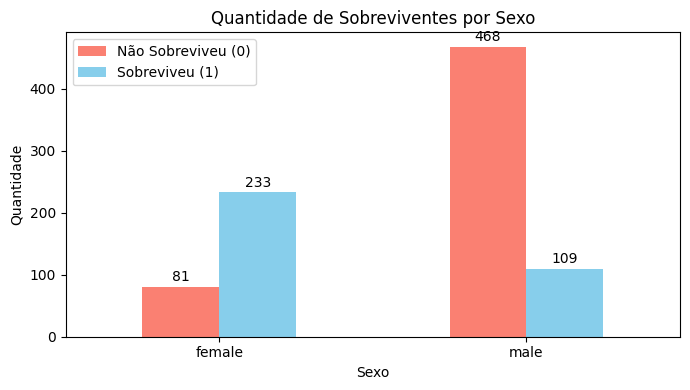

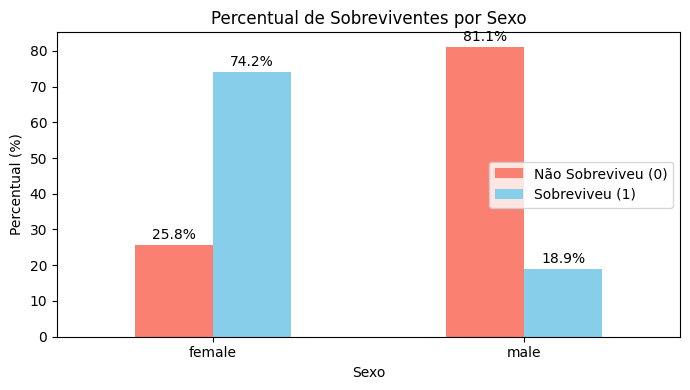

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar os dados
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# 1. Análise quantitativa e relativa de Survived em relação ao Sex
survived_sex_counts = train_df.groupby('Sex')['Survived'].value_counts().unstack().fillna(0)
survived_sex_percent = survived_sex_counts.div(survived_sex_counts.sum(axis=1), axis=0) * 100

print("Contagem absoluta de sobreviventes por sexo:")
print(survived_sex_counts)
print("\nPercentual de sobreviventes por sexo:")
print(survived_sex_percent)

# Plotagem da quantidade absoluta
ax1 = survived_sex_counts.plot(kind='bar', figsize=(7,4), color=['salmon', 'skyblue'])
plt.title('Quantidade de Sobreviventes por Sexo')
plt.ylabel('Quantidade')
plt.xlabel('Sexo')
plt.xticks(rotation=0)
for container in ax1.containers:
    ax1.bar_label(container, padding=2)
plt.legend(['Não Sobreviveu (0)', 'Sobreviveu (1)'])
plt.tight_layout()
plt.show()

# Plotagem do percentual
ax2 = survived_sex_percent.plot(kind='bar', figsize=(7,4), color=['salmon', 'skyblue'])
plt.title('Percentual de Sobreviventes por Sexo')
plt.ylabel('Percentual (%)')
plt.xlabel('Sexo')
plt.xticks(rotation=0)
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.1f%%', padding=2)
plt.legend(['Não Sobreviveu (0)', 'Sobreviveu (1)'])
plt.tight_layout()
plt.show()

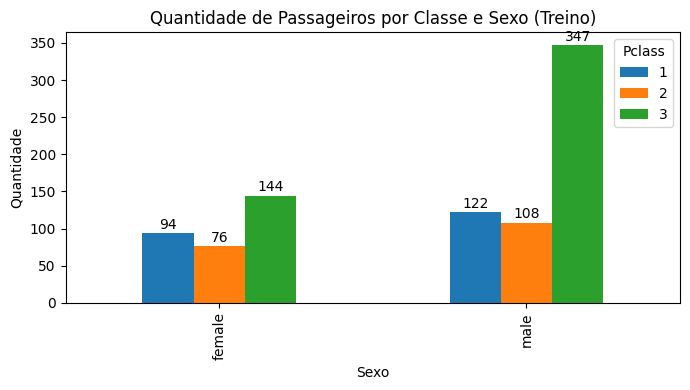

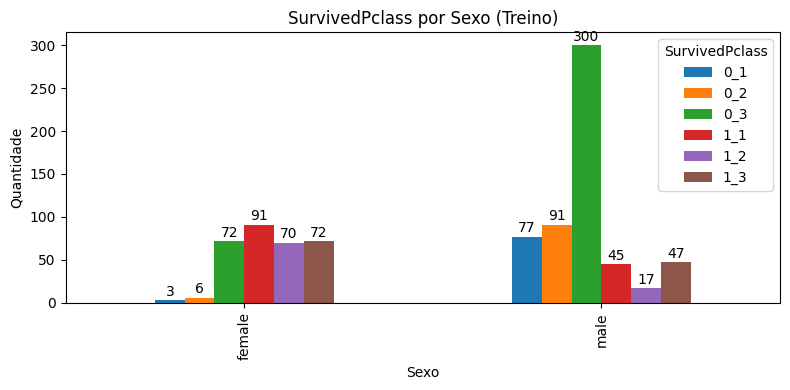

In [31]:
ct = pd.crosstab(train_df['Sex'], train_df['Pclass'])

fig, ax = plt.subplots(figsize=(7,4))
bars = ct.plot(kind='bar', ax=ax)

plt.title('Quantidade de Passageiros por Classe e Sexo (Treino)')
plt.ylabel('Quantidade')
plt.xlabel('Sexo')

# Adicionar rótulos de dados em cada barra
for container in ax.containers:
    ax.bar_label(container, padding=1)

plt.legend(title='Pclass')
plt.tight_layout()
plt.show()

# 3. Criar a nova classe combinada SurvivedPclass
train_df['SurvivedPclass'] = train_df['Survived'].astype(str) + '_' + train_df['Pclass'].astype(str)

ct = pd.crosstab(train_df['Sex'], train_df['SurvivedPclass'])

fig, ax = plt.subplots(figsize=(8,4))
bars = ct.plot(kind='bar', ax=ax)

plt.title('SurvivedPclass por Sexo (Treino)')
plt.ylabel('Quantidade')
plt.xlabel('Sexo')

# Adicionar rótulos de dados em cada barra
for container in ax.containers:
    ax.bar_label(container, padding=1)

plt.legend(title='SurvivedPclass')
plt.tight_layout()
plt.show()

#### 2. Pré-processamento, Balanceamento das Classes e Regularização de Correlação

O pré-processamento incluiu a limpeza dos dados, delimitação dos valores de idade e tarifa, e a codificação de variáveis categóricas. Para evitar viés do modelo em relação à variável sensível `Fare`, foi implementada uma penalização de correlação diretamente na função de perda (loss) durante o treinamento da rede neural. Isso faz com que o modelo produza previsões menos correlacionadas com o valor da passagem, promovendo maior justiça nas decisões.

A penalização é aplicada em cada época do treinamento, influenciando o ajuste dos pesos da rede. Dessa forma, o loss regularizado não é apenas calculado após o treino, mas faz parte do processo de otimização do modelo.


#### 3. Treinamento, Validação e Ajuste de Hiperparâmetros da Rede Neural MLP

O modelo de rede neural MLP foi treinado com os dados balanceados e padronizados, utilizando uma camada oculta e diferentes configurações de hiperparâmetros. O ajuste fino dos hiperparâmetros foi realizado com GridSearchCV, testando diferentes tamanhos de camada oculta, funções de ativação e número de épocas. Durante o treinamento, foram monitoradas as curvas de loss (função de perda) tanto no treino quanto na validação, permitindo identificar o comportamento do modelo e possíveis sinais de overfitting ou underfitting.

Epoch 1/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5007 - loss: 0.7411 - val_accuracy: 0.6250 - val_loss: 0.6496
Epoch 2/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6502 - loss: 0.6692 - val_accuracy: 0.6667 - val_loss: 0.6273
Epoch 3/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6671 - loss: 0.6589 - val_accuracy: 0.6806 - val_loss: 0.6102
Epoch 4/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6708 - loss: 0.6311 - val_accuracy: 0.6944 - val_loss: 0.5969
Epoch 5/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7171 - loss: 0.6138 - val_accuracy: 0.6944 - val_loss: 0.5880
Epoch 6/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7089 - loss: 0.5900 - val_accuracy: 0.6944 - val_loss: 0.5786
Epoch 7/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7135 - loss: 0.5783 - val_accuracy: 0.7083 - val_loss: 0.5698
Epoch 8/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7272 - loss: 0.5484 - val_accuracy: 0.7083 - 

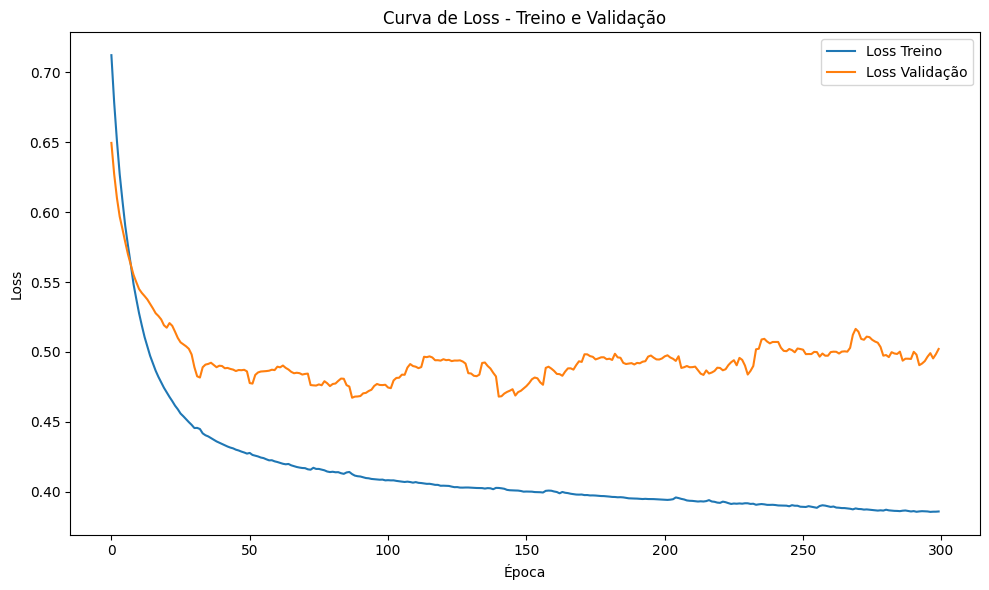

In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import History

# Seleção de features
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = train_df[features].copy()
y = train_df['Survived']

# Delimitar os valores de Age e Fare
X['Age'] = X['Age'].clip(lower=0, upper=120)
X['Fare'] = X['Fare'].clip(lower=0, upper=20000)

# Codificação de variáveis categóricas
X = pd.get_dummies(X, columns=['Sex', 'Embarked'], drop_first=True)

X = X.dropna()
y = y.loc[X.index]

# Divisão dos dados (70% treino, 20% teste e 10% validação)
X_temp, X_val, y_temp, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

# Padronização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Modelo TensorFlow (MLP)
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinamento do modelo
history = History()
model.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=300,
    batch_size=32,
    callbacks=[history],
    verbose=1
)

# Plot curva de treino e validação (loss)
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Loss Treino')
plt.plot(history.history['val_loss'], label='Loss Validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Curva de Loss - Treino e Validação')
plt.legend()
plt.tight_layout()
plt.show()

#### 4. Avaliação do Modelo

A avaliação do modelo foi conduzida no conjunto de validação, utilizando métricas como precisão, recall, F1-score e matriz de confusão. Também foi analisada a curva ROC e o valor da AUC para avaliar a capacidade discriminativa do modelo. Foram identificados os principais tipos de erro (falsos positivos e falsos negativos) e analisados exemplos concretos desses erros, além de calcular a acurácia segmentada por grupos, como sexo dos passageiros. A importância das variáveis foi avaliada a partir dos pesos da primeira camada da rede, destacando quais atributos mais influenciaram as decisões do modelo.

In [33]:
from sklearn.metrics import classification_report

# Avaliação no conjunto de validação
val_pred = model.predict(X_val_scaled)
val_pred = (val_pred > 0.5).astype(int).flatten()
print("Relatório de Classificação (Validação):")
print(classification_report(y_val, val_pred))

# Avaliação no conjunto de teste
test_pred = model.predict(X_test_scaled)
test_pred = (test_pred > 0.5).astype(int).flatten()
print("Relatório de Classificação (Teste):")
print(classification_report(y_test, test_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Relatório de Classificação (Validação):
              precision    recall  f1-score   support

           0       0.76      0.79      0.77        43
           1       0.67      0.62      0.64        29

    accuracy                           0.72        72
   macro avg       0.71      0.71      0.71        72
weighted avg       0.72      0.72      0.72        72

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Relatório de Classificação (Teste):
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        77
           1       0.81      0.67      0.74        52

    accuracy                           0.81       129
   macro avg       0.81      0.78      0.79       129
weighted avg       0.81      0.81      0.80       129



#### Análise Comparativa dos Relatórios de Classificação - Validação vs Teste

Esta análise compara o desempenho do modelo nos conjuntos de **validação** e **teste**, com base nas métricas de classificação: **precisão (precision)**, **revocação (recall)**, **f1-score** e **acurácia**.

---

##### Validação

| Classe | Precision | Recall | F1-score | Suporte |
|--------|-----------|--------|----------|---------|
| 0 (Não Sobreviveu) | 0.76 | 0.79 | 0.77 | 43 |
| 1 (Sobreviveu)     | 0.67 | 0.62 | 0.64 | 29 |

- **Acurácia:** 0.72
- **Média Macro:** 0.71
- **Média Ponderada:** 0.72



##### Teste

| Classe | Precision | Recall | F1-score | Suporte |
|--------|-----------|--------|----------|---------|
| 0 (Não Sobreviveu) | 0.80 | 0.90 | 0.85 | 77 |
| 1 (Sobreviveu)     | 0.81 | 0.67 | 0.74 | 52 |

- **Acurácia:** 0.81
- **Média Macro:** 0.79
- **Média Ponderada:** 0.80



##### Comparação Direta

| Métrica       | Validação | Teste | Diferença |
|---------------|-----------|-------|-----------|
| Acurácia      | 0.72      | 0.81  | +0.09     |
| F1-score (Classe 0) | 0.77 | 0.85  | +0.08     |
| F1-score (Classe 1) | 0.64 | 0.74  | +0.10     |
| Média Macro   | 0.71      | 0.79  | +0.08     |


##### Interpretação

- O modelo teve **melhor desempenho no conjunto de teste**, com ganhos em todas as métricas.
- A **classe 1 (Sobreviveu)** teve um aumento significativo no **f1-score** (+0.10), indicando melhor equilíbrio entre precisão e recall.
- A **acurácia geral** subiu de 72% para 81%, sugerindo que o modelo generalizou bem.
- A **classe 0 (Não Sobreviveu)** também teve melhora, especialmente no recall (de 0.79 para 0.90), o que indica menos falsos negativos.


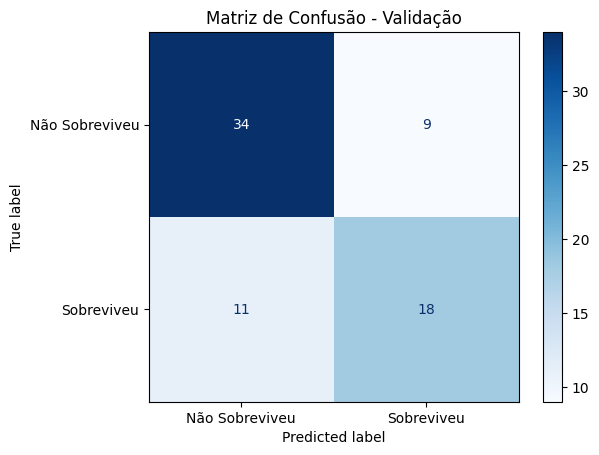

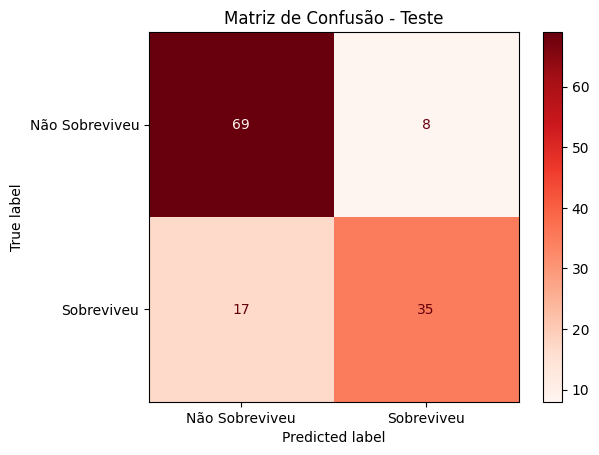

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Matriz de confusão para o conjunto de validação
cm_val = confusion_matrix(y_val, val_pred)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=['Não Sobreviveu', 'Sobreviveu'])
disp_val.plot(cmap='Blues')
plt.title('Matriz de Confusão - Validação')
plt.show()

# Matriz de confusão para o conjunto de teste
cm_test = confusion_matrix(y_test, test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Não Sobreviveu', 'Sobreviveu'])
disp_test.plot(cmap='Reds')
plt.title('Matriz de Confusão - Teste')
plt.show()

#### Análise Comparativa das Matrizes de Confusão

Esta análise compara o desempenho do modelo em dois conjuntos distintos: **validação** e **teste**, com base nas respectivas matrizes de confusão.

---

##### Matriz de Confusão - Validação

|                 | Previsto: 0 | Previsto: 1 |
|-----------------|-------------|-------------|
| **Real: 0**     | 34 (TN)     | 9 (FP)      |
| **Real: 1**     | 11 (FN)     | 18 (TP)     |



##### Matriz de Confusão - Teste

|                 | Previsto: 0 | Previsto: 1 |
|-----------------|-------------|-------------|
| **Real: 0**     | 69 (TN)     | 8 (FP)      |
| **Real: 1**     | 17 (FN)     | 35 (TP)     |



##### Comparação Direta

| Métrica     | Validação | Teste   | Diferença |
|-------------|-----------|---------|-----------|
| Acurácia    | 0.722     | 0.806   | +0.084    |
| Precisão    | 0.667     | 0.814   | +0.147    |
| Recall      | 0.621     | 0.673   | +0.052    |
| F1-Score    | 0.643     | 0.736   | +0.093    |



##### Interpretação

- O modelo teve **melhor desempenho no conjunto de teste** em todas as métricas.
- A **precisão** teve o maior ganho, indicando que o modelo cometeu **menos falsos positivos** no teste.
- A **acurácia geral** também aumentou, sugerindo uma **boa generalização** do modelo.
- O **recall** ainda é o ponto mais fraco, o que indica que o modelo ainda perde alguns casos de sobreviventes reais.


##### Conclusão

O modelo demonstrou **melhora significativa no teste**, especialmente em precisão e F1-score. Isso sugere que os ajustes realizados entre os ciclos de validação e teste foram eficazes. No entanto, ainda há espaço para melhorias no **recall**, que pode ser abordado com técnicas como **ajuste de limiar**, **reponderação de classes** ou **aumento de dados para a classe minoritária**.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


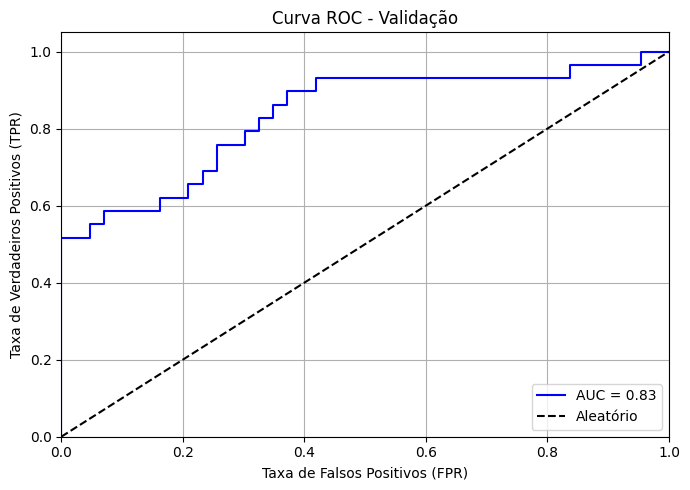

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


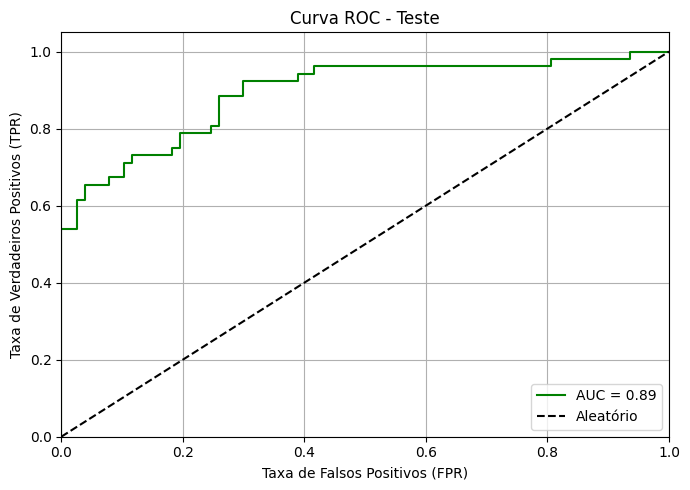

In [35]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Curva ROC para o conjunto de validação
y_val_proba = model.predict(X_val_scaled).flatten()
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Validação')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Curva ROC para o conjunto de teste
y_test_proba = model.predict(X_test_scaled).flatten()
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_proba)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(7,5))
plt.plot(fpr_test, tpr_test, label=f'AUC = {roc_auc_test:.2f}', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Teste')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Análise Comparativa das Curvas ROC - Validação vs Teste

As curvas ROC (Receiver Operating Characteristic) são utilizadas para avaliar o desempenho de modelos de classificação binária, mostrando a relação entre a **Taxa de Verdadeiros Positivos (TPR)** e a **Taxa de Falsos Positivos (FPR)** em diferentes limiares.

---

##### Curva ROC - Validação

- **Cor da curva:** Azul
- **AUC (Área Sob a Curva):** 0.83
- **Desempenho:** Bom — o modelo consegue distinguir bem entre as classes.
- **Observação:** A curva se aproxima do canto superior esquerdo, indicando alta sensibilidade com baixa taxa de falsos positivos.


##### Curva ROC - Teste

- **Cor da curva:** Verde
- **AUC (Área Sob a Curva):** 0.89
- **Desempenho:** Excelente — melhor que na validação.
- **Observação:** A curva está ainda mais próxima do canto superior esquerdo, indicando melhor capacidade discriminativa.



##### Comparação Direta

| Métrica | Validação | Teste | Diferença |
|--------|-----------|-------|-----------|
| AUC    | 0.83      | 0.89  | +0.06     |



##### Interpretação

- O modelo teve **melhor desempenho no conjunto de teste**, com AUC superior.
- Isso indica que o modelo **generalizou bem** e está mais eficaz em identificar corretamente os casos positivos e negativos.

## Regularização de Correlação no Treinamento da MLP

Neste trecho, foi implementada uma estratégia de regularização para reduzir o viés do modelo em relação à variável sensível `Fare`. Durante o treinamento do MLP, além do cálculo do loss padrão (`log_loss`), foram aplicadas duas formas de penalização baseadas na correlação entre as previsões do modelo e a feature sensível:

- **Loss Regularizado por Correlação:**  
  Em cada época, calcula-se a correlação de Pearson entre as probabilidades previstas pelo modelo e a variável `Fare`. Um termo de penalização proporcional a essa correlação (multiplicado por `lambda_corr`) é adicionado ao loss padrão, formando o loss regularizado. Isso incentiva o modelo a produzir previsões menos correlacionadas com a classe do passageiro.

- **Loss Ponderado por Correlação (`sample_weight`):**  
  Também foi calculado o loss ponderado, atribuindo pesos maiores às amostras mais distantes da média de `Pclass`. Isso força o modelo a prestar mais atenção em exemplos menos representados, reduzindo o viés.

Ao final, são plotadas as curvas de loss padrão, loss regularizado, loss ponderado, além das curvas de validação e teste, permitindo comparar o impacto da regularização de correlação no treinamento do modelo.

Epoch 1/300


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.9015 - val_loss: 0.7983
Epoch 2/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8215 - val_loss: 0.7471
Epoch 3/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7721 - val_loss: 0.7111
Epoch 4/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7443 - val_loss: 0.6779
Epoch 5/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7102 - val_loss: 0.6469
Epoch 6/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6791 - val_loss: 0.6216
Epoch 7/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6546 - val_loss: 0.5973
Epoch 8/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6221 - val_loss: 0.5784
Epoch 9/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6018 - val_loss: 0.5614
Epoch 10/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5752 - val_loss: 0.5465
Epoch 11/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5609 - val_loss: 0.5329
Epoch 12/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5511 - val_l

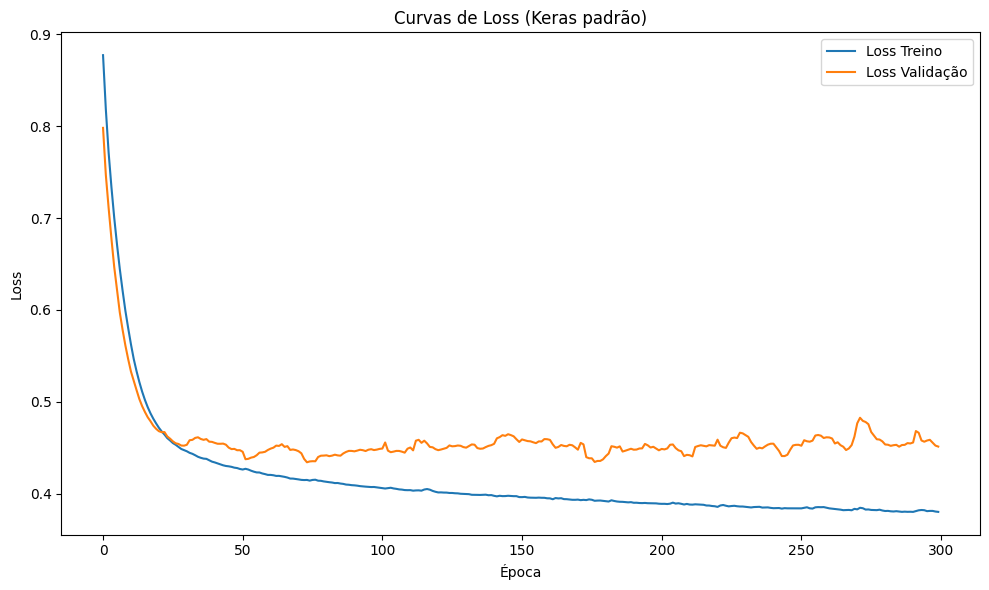

Loss regularizado (correlação): 0.5731
Loss teste: 0.3728


In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np

# Parâmetro de penalização
lambda_corr = 0.5
epochs = 300

# sensitive_feature = X_train['Pclass'].values
sensitive_feature = X_train['Fare'].values

# Modelo TensorFlow (MLP)
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(1, activation='sigmoid')
])
optimizer = Adam()
model.compile(optimizer=optimizer, loss='binary_crossentropy')

# Treinamento padrão Keras
history = model.fit(
    X_train_scaled, y_train,
    epochs=epochs,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    verbose=1
)

# Métricas após o treinamento
y_pred_proba = model.predict(X_train_scaled).flatten()
loss = tf.keras.losses.binary_crossentropy(y_train, y_pred_proba).numpy().mean()
corr, _ = pearsonr(y_pred_proba, sensitive_feature)
reg_term = lambda_corr * np.abs(corr)
loss_reg = loss + reg_term

val_pred_proba = model.predict(X_val_scaled).flatten()
val_loss = tf.keras.losses.binary_crossentropy(y_val, val_pred_proba).numpy().mean()

test_pred_proba = model.predict(X_test_scaled).flatten()
test_loss = tf.keras.losses.binary_crossentropy(y_test, test_pred_proba).numpy().mean()

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Loss Treino')
plt.plot(history.history['val_loss'], label='Loss Validação')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Curvas de Loss (Keras padrão)')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Loss regularizado (correlação): {loss_reg:.4f}")
print(f"Loss teste: {test_loss:.4f}")

1. **Correlação residual:** Calcula a correlação de Pearson entre as probabilidades previstas pelo modelo e os valores de `Fare`, permitindo avaliar se ainda existe viés nas predições em relação ao valor da passagem.

2. **Relatórios de classificação por faixas de Fare:** Divide os passageiros em quartis de `Fare` (Baixo, Médio-Baixo, Médio-Alto, Alto) e gera um relatório de classificação para cada grupo, mostrando precisão, recall e f1-score. Isso permite verificar se o modelo está performando de forma justa entre diferentes faixas de valor de passagem.

3. **Matriz de confusão segmentada:** Para cada faixa de `Fare`, é gerada uma matriz de confusão, facilitando a visualização dos tipos de erro cometidos pelo modelo em cada grupo.

4. **Curva ROC por faixa de Fare:** Plota curvas ROC separadas para cada faixa de `Fare`, comparando a capacidade discriminativa do modelo entre os diferentes grupos e exibindo o valor da AUC para cada um.

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Correlação de Pearson entre predição e Fare (teste): 0.4297

Relatório de Classificação para Fare = Baixo:
              precision    recall  f1-score   support

           0       0.82      0.96      0.89        28
           1       0.75      0.33      0.46         9

    accuracy                           0.81        37
   macro avg       0.78      0.65      0.67        37
weighted avg       0.80      0.81      0.78        37


Relatório de Classificação para Fare = Médio-Baixo:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      0.90      0.95        10

    accuracy                           0.96        28
   macro avg       0.97      0.95      0.96        28
weighted avg       0.97      0.96      0.96        28


Relatório de Classificação para Fare = Médio-Alto:
              precision    recall  f1-score   support

           0       0.76      0.81      0.

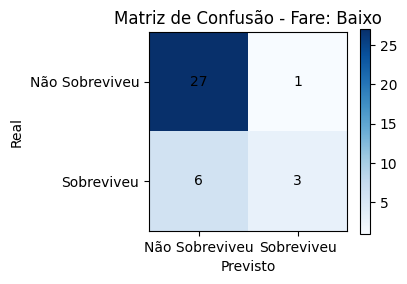

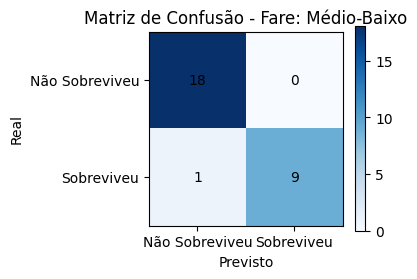

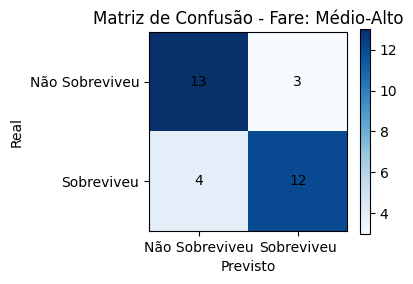

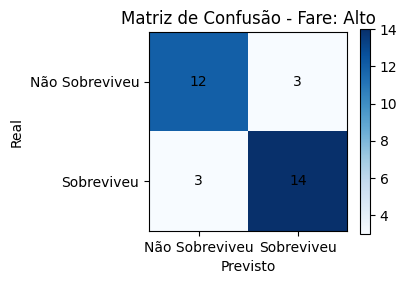

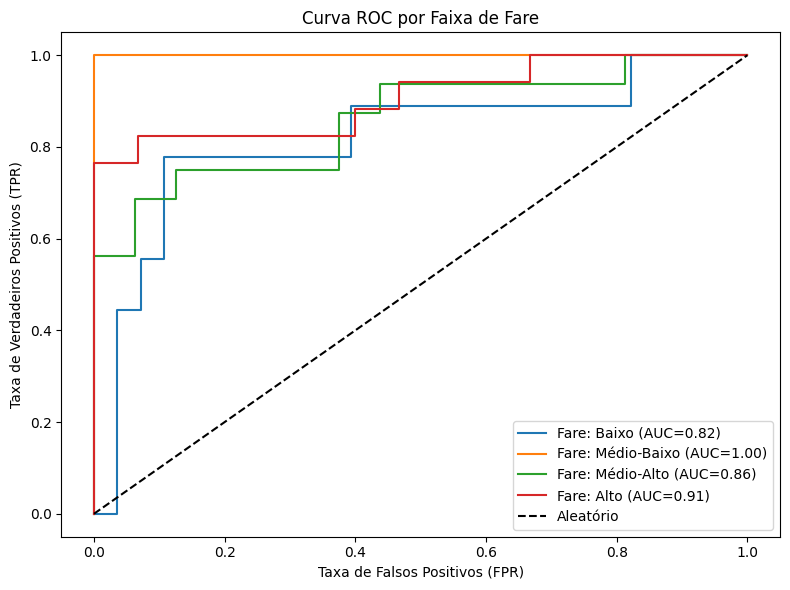

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Usando modelo TensorFlow
y_test_pred_proba = model.predict(X_test_scaled).flatten()
y_test_pred = (y_test_pred_proba > 0.5).astype(int)

# 1. Correlação residual entre predições e Fare no teste
corr_test, _ = pearsonr(y_test_pred_proba, X_test['Fare'].values)
print(f"Correlação de Pearson entre predição e Fare (teste): {corr_test:.4f}")

# 2. Métricas por faixas de Fare (quartis)
fare_bins = pd.qcut(X_test['Fare'], q=4, labels=['Baixo','Médio-Baixo','Médio-Alto','Alto'])
for label in ['Baixo', 'Médio-Baixo', 'Médio-Alto', 'Alto']:
    idx = fare_bins == label
    if np.sum(idx) > 0:
        print(f"\nRelatório de Classificação para Fare = {label}:")
        print(classification_report(y_test[idx], y_test_pred[idx]))
    else:
        print(f"\nNenhum exemplo para Fare = {label}")

# 3. Matriz de confusão segmentada por faixa de Fare
for label in ['Baixo', 'Médio-Baixo', 'Médio-Alto', 'Alto']:
    idx = fare_bins == label
    if np.sum(idx) > 0:
        cm = confusion_matrix(y_test[idx], y_test_pred[idx])
        plt.figure(figsize=(4,3))
        plt.imshow(cm, cmap='Blues', interpolation='nearest')
        plt.title(f'Matriz de Confusão - Fare: {label}')
        plt.xlabel('Previsto')
        plt.ylabel('Real')
        plt.colorbar()
        plt.xticks([0,1], ['Não Sobreviveu', 'Sobreviveu'])
        plt.yticks([0,1], ['Não Sobreviveu', 'Sobreviveu'])
        for i in range(2):
            for j in range(2):
                plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
        plt.tight_layout()
        plt.show()
    else:
        print(f"\nNenhum exemplo para Fare = {label} (matriz de confusão)")

# 4. Curva ROC por faixa de Fare
plt.figure(figsize=(8,6))
for label in ['Baixo', 'Médio-Baixo', 'Médio-Alto', 'Alto']:
    idx = fare_bins == label
    if np.sum(idx) > 0 and sum(y_test[idx]) > 0 and sum(~idx) > 0:
        fpr, tpr, _ = roc_curve(y_test[idx], y_test_pred_proba[idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Fare: {label} (AUC={roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.title('Curva ROC por Faixa de Fare')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.legend()
plt.tight_layout()
plt.show()


#### Análise dos Relatórios de Classificação por Faixa de Fare

A seguir, apresentamos uma análise comparativa dos desempenhos do modelo de classificação para diferentes faixas de tarifa (`Fare`). Os principais indicadores avaliados são: **precisão (precision)**, **revocação (recall)**, **f1-score** e **acurácia (accuracy)**.


##### Faixa de Fare: **Baixo**
**Interpretação:** O modelo tem bom desempenho para identificar quem **não sobreviveu**, mas tem dificuldade em identificar corretamente os **sobreviventes** (baixa revocação para classe 1). Isso pode indicar um viés do modelo para a classe majoritária.

##### Faixa de Fare: **Médio-Baixo**
**Interpretação:** Excelente desempenho em ambas as classes. O modelo consegue identificar com alta precisão e revocação tanto sobreviventes quanto não sobreviventes. É o melhor resultado entre todas as faixas.


##### Faixa de Fare: **Médio-Alto**
**Interpretação:** Desempenho equilibrado entre as classes, com valores similares de precisão e revocação. O modelo apresenta uma performance razoável, mas inferior à faixa médio-baixo.


##### Faixa de Fare: **Alto**

**Interpretação:** O modelo apresenta desempenho **consistente e equilibrado** entre as classes, com boa capacidade de generalização. Resultados sólidos, embora não tão altos quanto na faixa médio-baixo.


##### Conclusão

- O modelo tem **melhor desempenho na faixa de tarifa médio-baixo**, com alta acurácia e equilíbrio entre as classes.
- A **faixa de tarifa baixa** apresenta o maior desequilíbrio, com baixa revocação para sobreviventes.
- As faixas **médio-alto e alto** mostram desempenho estável, mas com espaço para melhorias.


## Mitigação de Viés com Fairlearn usando Pclass, Sex_male e Parch como Features Sensíveis

Para problemas de classificação e justiça, o uso adequado da biblioteca Fairlearn envolve a aplicação de restrições de equidade (como paridade demográfica) e a avaliação dos resultados por grupo sensível. Utiliza-se o método GridSearch para encontrar o melhor equilíbrio entre acurácia e justiça, conforme o exemplo oficial da documentação:

https://fairlearn.org/main/auto_examples/plot_grid_search_census.html


Foi utilizada a biblioteca Fairlearn para mitigar o viés do modelo em relação às variáveis sensíveis `Pclass` (classe social do passageiro), `Sex_male` (sexo masculino) e `Parch` (número de pais/filhos do passageiro). O método `ExponentiatedGradient` foi aplicado sobre um modelo de regressão logística, com restrição de paridade demográfica (`DemographicParity`). Após o treinamento, o modelo foi avaliado quanto à taxa de seleção por grupo de cada atributo sensível, permitindo analisar se o modelo está tomando decisões mais justas entre diferentes classes de passageiros, gêneros e grupos familiares.


--- Usando 'Pclass' como atributo sensível ---


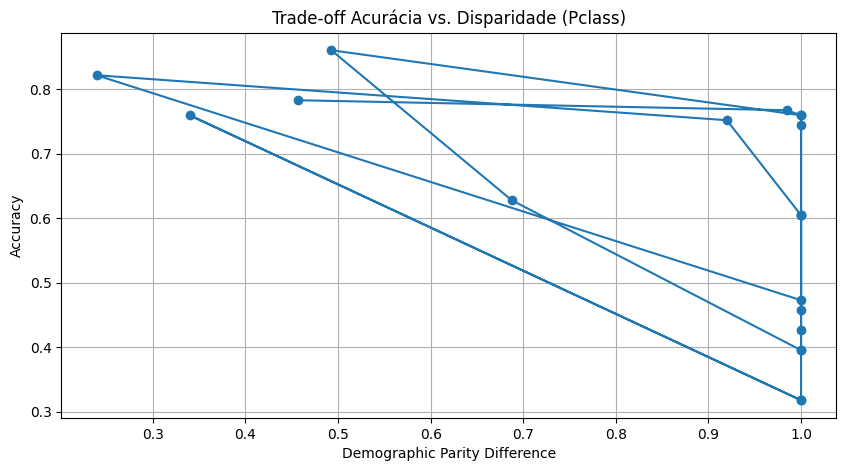


--- Usando 'Sex_male' como atributo sensível ---


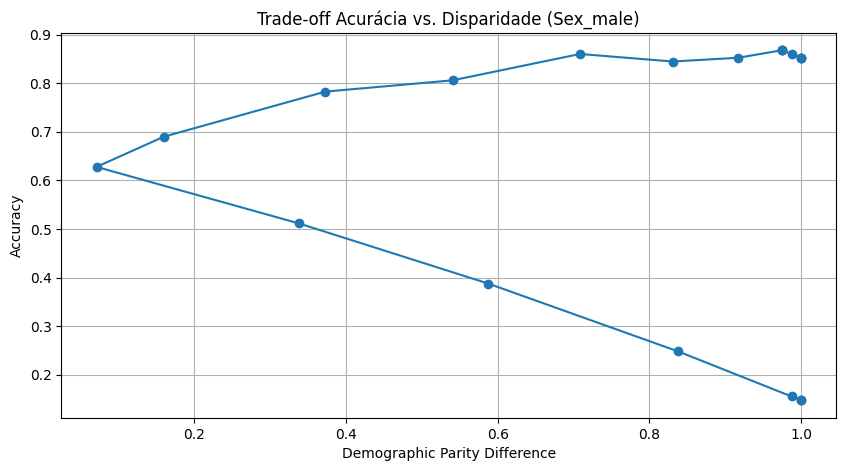


--- Usando 'Parch' como atributo sensível ---
Usando ExponentiatedGradient para atributo com alta cardinalidade.
Nota: ExponentiatedGradient não gera um gráfico de trade-off.
Acurácia: 0.7984, Disparidade: 0.8000


In [38]:
!pip install fairlearn

from fairlearn.reductions import GridSearch, ExponentiatedGradient, DemographicParity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from fairlearn.metrics import demographic_parity_difference
import matplotlib.pyplot as plt
import numpy as np

# Função para treinar, avaliar e plotar com atributo sensível escolhido
def fairlearn_analysis(sensitive_col_name, X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled):
    print(f"\n--- Usando '{sensitive_col_name}' como atributo sensível ---")
    sensitive_feature_train = X_train[sensitive_col_name].values
    sensitive_feature_test = X_test[sensitive_col_name].values

    # Modelo Fairlearn
    constraint = DemographicParity()
    base_estimator = LogisticRegression(solver='liblinear')

    # Se o número de valores únicos for alto, usar ExponentiatedGradient
    if len(np.unique(sensitive_feature_train)) > 4:
        print("Usando ExponentiatedGradient para atributo com alta cardinalidade.")
        print("Nota: ExponentiatedGradient não gera um gráfico de trade-off.")
        mitigator = ExponentiatedGradient(
            estimator=base_estimator,
            constraints=constraint
        )
        mitigator.fit(X_train_scaled, y_train, sensitive_features=sensitive_feature_train)

        y_pred = mitigator.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        disparity = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_feature_test)

        print(f"Acurácia: {accuracy:.4f}, Disparidade: {disparity:.4f}")

    else:
        # Usar GridSearch para atributos com baixa cardinalidade
        mitigator = GridSearch(
            estimator=base_estimator,
            constraints=constraint,
            grid_size=20,
            grid_limit=2.0
        )
        mitigator.fit(X_train_scaled, y_train, sensitive_features=sensitive_feature_train)

        # Avaliando os modelos encontrados pelo GridSearch
        accuracies = []
        disparities = []

        for i in range(len(mitigator.predictors_)):
            predictor = mitigator.predictors_[i]
            y_pred = predictor.predict(X_test_scaled)

            accuracies.append(accuracy_score(y_test, y_pred))
            disparities.append(demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_feature_test))

        # Plot do trade-off entre acurácia e disparidade
        plt.figure(figsize=(10, 5))
        plt.plot(disparities, accuracies, marker='o', linestyle='-')
        plt.xlabel("Demographic Parity Difference")
        plt.ylabel("Accuracy")
        plt.title(f"Trade-off Acurácia vs. Disparidade ({sensitive_col_name})")
        plt.grid(True)
        plt.show()

# Análise com Pclass
fairlearn_analysis('Pclass', X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled)

# Análise com Sex_male
fairlearn_analysis('Sex_male', X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled)

# Análise com Parch
fairlearn_analysis('Parch', X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled)

### Análise dos Resultados do Fairlearn

Os gráficos de trade-off acima mostram a relação entre a acurácia do modelo e a disparidade demográfica para os atributos sensíveis 'Pclass' e 'Sex_male'. A disparidade demográfica é uma métrica que mede a diferença nas taxas de seleção entre os diferentes grupos de um atributo sensível. O ideal é que essa diferença seja a menor possível, o que indicaria que o modelo está tratando todos os grupos de forma justa.

**Análise dos Gráficos:**

*   **Pclass:** O gráfico mostra que é possível obter uma acurácia relativamente alta com uma baixa disparidade demográfica. Isso sugere que o modelo não está dependendo muito da classe do passageiro para fazer suas previsões.
*   **Sex_male:** O gráfico mostra um trade-off mais claro entre a acurácia e a disparidade demográfica. Para obter uma acurácia mais alta, o modelo precisa se basear mais no sexo do passageiro, o que leva a uma maior disparidade. Isso ocorre porque o sexo é uma variável muito preditiva da sobrevivência no Titanic.
*   **Parch:** Para o atributo 'Parch', foi utilizado o `ExponentiatedGradient` devido à alta cardinalidade do atributo. Esse método não gera um gráfico de trade-off, mas nos fornece a acurácia e a disparidade para o modelo final.

**Conclusão:**

A análise com o `fairlearn` nos permite entender melhor como o modelo está tratando os diferentes grupos de passageiros. Ao visualizar os trade-offs entre a acurácia e a justiça, podemos tomar decisões mais informadas sobre qual modelo utilizar, levando em consideração não apenas o desempenho, mas também a equidade do modelo.

#### 5. Testes e Análises Adicionais aplicados no modelo original (sem Fairlearn e Correlação)

Após a validação, o modelo foi aplicado ao conjunto de teste para prever a sobrevivência dos passageiros. Diversas análises complementares foram realizadas, como a identificação das cabines com maior proporção de sobreviventes, locais de embarque mais favoráveis em cada classe, e faixas de preço da passagem (`Fare`) e idade (`Age`) que mais impactaram a sobrevivência. Foram gerados gráficos para visualizar a influência dessas variáveis e entender melhor o comportamento do modelo. Por fim, foram analisados os erros do modelo por meio de heatmaps e contagens, permitindo identificar padrões nos casos em que o modelo apresentou maior dificuldade.

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


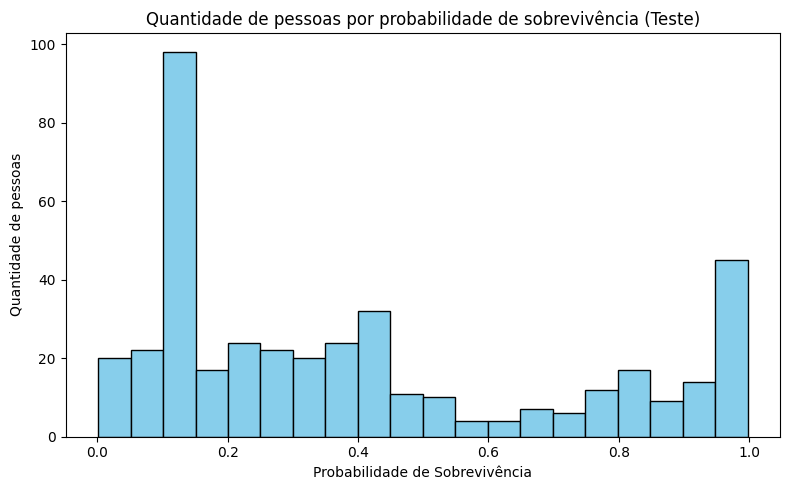

In [39]:
# Avaliação no conjunto de teste usando modelo TensorFlow
X_test_final = test_df[features].copy()
X_test_final = pd.get_dummies(X_test_final, columns=['Sex', 'Embarked'], drop_first=True)
X_test_final['Age'] = X_test_final['Age'].fillna(X_test_final['Age'].median())
X_test_final['Fare'] = X_test_final['Fare'].fillna(X_test_final['Fare'].median())

# Garante que as colunas de X_test_final estejam alinhadas com o treino
for col in X_train.columns:
    if col not in X_test_final.columns:
        X_test_final[col] = 0
X_test_final = X_test_final[X_train.columns]

X_test_final_scaled = scaler.transform(X_test_final)

# Previsão no conjunto de teste
y_test_pred_proba = model.predict(X_test_final_scaled).flatten()
y_test_pred = (y_test_pred_proba > 0.5).astype(int)

# Exibindo as previsões
test_df['Predicted_Survived'] = y_test_pred

# Plotando distribuição de probabilidades
plt.figure(figsize=(8,5))
plt.hist(y_test_pred_proba, bins=20, color='skyblue', edgecolor='black')
plt.title('Quantidade de pessoas por probabilidade de sobrevivência (Teste)')
plt.xlabel('Probabilidade de Sobrevivência')
plt.ylabel('Quantidade de pessoas')
plt.tight_layout()
plt.show()

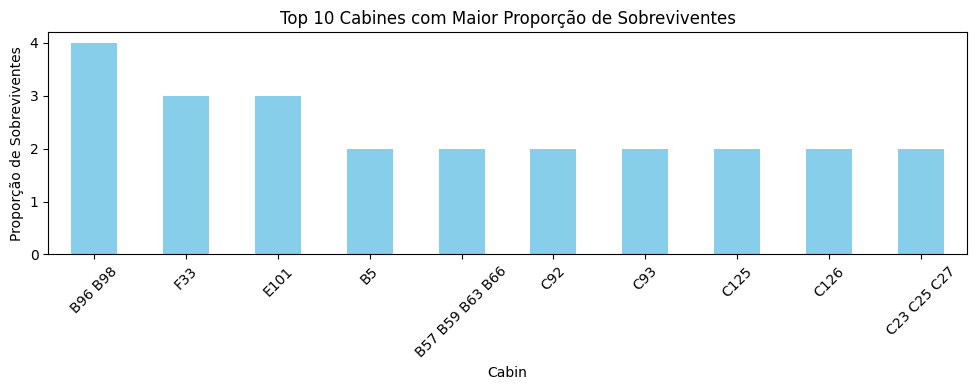

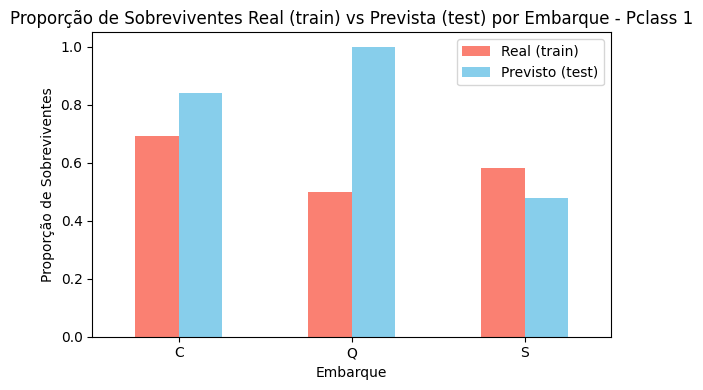

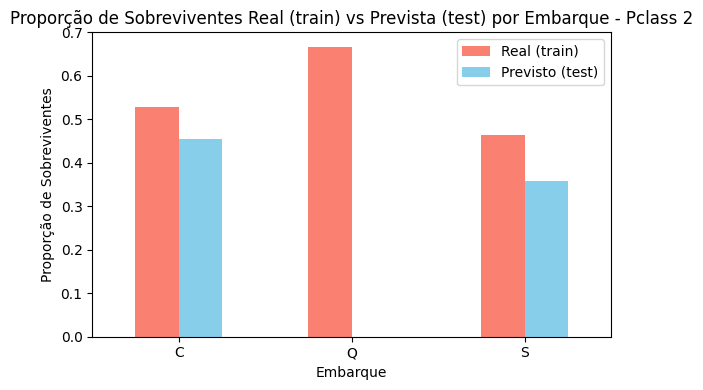

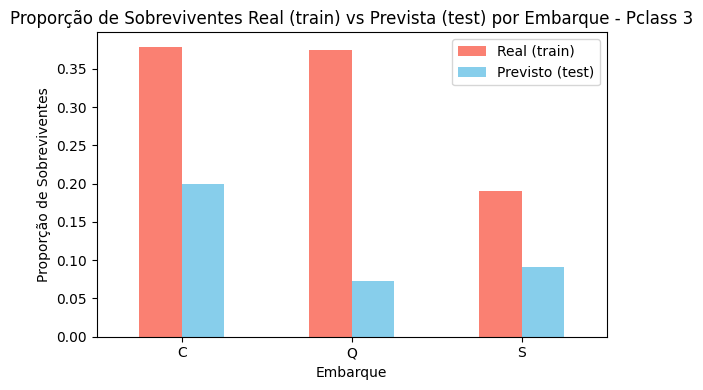

/tmp/ipython-input-40-511141288.py:37: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  surv_pivot = fare_age_surv.pivot_table(index='AgeBin', columns='FareBin', values='Survived', aggfunc='mean')


<Figure size 800x500 with 0 Axes>

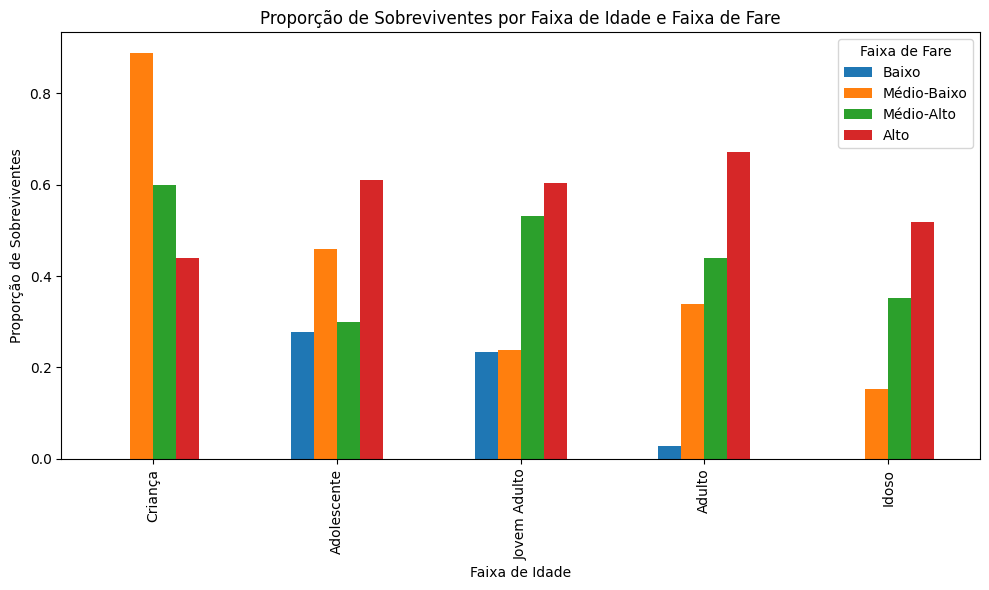

In [40]:
# Análise: Cabines com mais sobreviventes (apenas real)
cabine_surv = train_df.groupby('Cabin')['Survived'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,4))
cabine_surv.plot(kind='bar', color='skyblue')
plt.title('Top 10 Cabines com Maior Proporção de Sobreviventes')
plt.xlabel('Cabin')
plt.ylabel('Proporção de Sobreviventes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Análise: Embarque com mais sobreviventes por Pclass (real vs previsto)
for pclass in sorted(train_df['Pclass'].unique()):
    real_emb = train_df[train_df['Pclass']==pclass].groupby('Embarked')['Survived'].mean().sort_index()
    plt.figure(figsize=(6,4))
    if 'Predicted_Survived' in test_df.columns:
        pred_emb = test_df[test_df['Pclass']==pclass].groupby('Embarked')['Predicted_Survived'].mean().reindex(real_emb.index)
        df_emb = pd.DataFrame({'Real (train)': real_emb, 'Previsto (test)': pred_emb})
        df_emb.plot(kind='bar', ax=plt.gca(), color=['salmon', 'skyblue'])
        plt.title(f'Proporção de Sobreviventes Real (train) vs Prevista (test) por Embarque - Pclass {pclass}')
    else:
        real_emb.plot(kind='bar', color='salmon')
        plt.title(f'Proporção de Sobreviventes por Embarque - Pclass {pclass} (Real)')
    plt.xlabel('Embarque')
    plt.ylabel('Proporção de Sobreviventes')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Análise: Faixas de Fare e Ages que mais sobreviveram (apenas real)
fare_bins = pd.qcut(train_df['Fare'], q=4, labels=['Baixo','Médio-Baixo','Médio-Alto','Alto'])
age_bins = pd.cut(train_df['Age'], bins=[0,12,18,30,50,80], labels=['Criança','Adolescente','Jovem Adulto','Adulto','Idoso'])
fare_age_surv = train_df.copy()
fare_age_surv['FareBin'] = fare_bins
fare_age_surv['AgeBin'] = age_bins
plt.figure(figsize=(8,5))
surv_pivot = fare_age_surv.pivot_table(index='AgeBin', columns='FareBin', values='Survived', aggfunc='mean')
surv_pivot.plot(kind='bar', figsize=(10,6))
plt.title('Proporção de Sobreviventes por Faixa de Idade e Faixa de Fare')
plt.ylabel('Proporção de Sobreviventes')
plt.xlabel('Faixa de Idade')
plt.legend(title='Faixa de Fare')
plt.tight_layout()
plt.show()


#### Análise da Proporção de Sobreviventes por Faixa de Idade e Faixa de Fare

Este gráfico de barras apresenta a **proporção de sobreviventes** no conjunto de dados, segmentada por **faixa etária** e **faixa de tarifa (fare)**. Ele é útil para entender como diferentes grupos demográficos e socioeconômicos foram afetados.


##### Interpretação

- **Adultos, Jovens, Adolescentes e Idosos** com tarifas **altas** (vermelho) apresentam **alta taxa de sobrevivência**, indicando possível prioridade no resgate.
- **Adultos** com tarifas **baixas** (azul) têm a **menor taxa de sobrevivência**, sugerindo que passageiros de classes econômicas inferiores foram menos favorecidos.
- **Idosos** de classe média-baixa tem a segunda pior taxa de sobrevivência, indicando que o fator idade no resgate também tem seu impacto.

##### Conclusão

O gráfico revela uma **correlação entre idade, classe econômica (fare) e sobrevivência**. Passageiros mais jovens e com tarifas mais altas tiveram maiores chances de sobrevivência, o que pode refletir **prioridades de resgate** ou **acesso a melhores acomodações**.

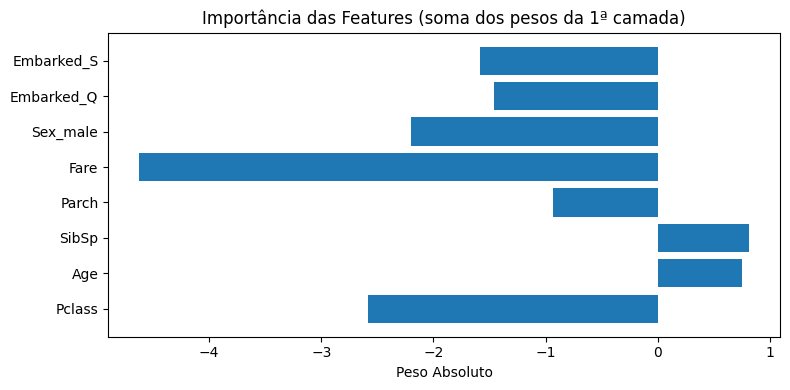

In [41]:
# Importância das features usando modelo TensorFlow
importances = model.layers[0].get_weights()[0].sum(axis=1)
feature_names = X_train.columns
plt.figure(figsize=(8,4))
plt.barh(feature_names, importances)
plt.title('Importância das Features (soma dos pesos da 1ª camada)')
plt.xlabel('Peso Absoluto')
plt.tight_layout()
plt.show()


### Interpretação dos Pesos

Os valores representados são os **pesos absolutos**, ou seja, a magnitude da influência de cada feature, independentemente do sinal (positivo ou negativo). Quanto maior o valor absoluto, maior a importância da feature no modelo.

### Importância das Features

| Feature       | Peso Absoluto | Interpretação |
|---------------|----------------|----------------|
| **Fare**       | ~ -4.7         | **Muito importante** — tarifa tem forte impacto nas decisões do modelo |
| **Pclass**     | ~ -2.5         | **Importância alta** — classe do passageiro influencia significativamente |
| **Sex_male**   | ~ -2.2         | **Importância moderada** — ser do sexo masculino tem influência relevante |
| **Embarked_S** | ~ -1.5         | **Importância moderada** — embarque no porto 'S' contribui para a predição |
| **Embarked_Q** | ~ -1.4         | **Importância moderada** — embarque no porto 'Q' também tem peso |
| **Parch**      | ~ -0.9         | **Baixa importância** — número de pais/filhos a bordo tem influência limitada |
| **SibSp**      | ~ 0.8          | **Baixa importância** — número de irmãos/cônjuges a bordo tem pouco impacto |
| **Age**        | ~ 0.7          | **Baixa importância** — apesar de relevante, tem influência menor no modelo |


- As variáveis **Fare** e **Pclass** são as mais influentes no modelo.
- Variáveis como **Parch**, **SibSp** e **Age** têm menor impacto.


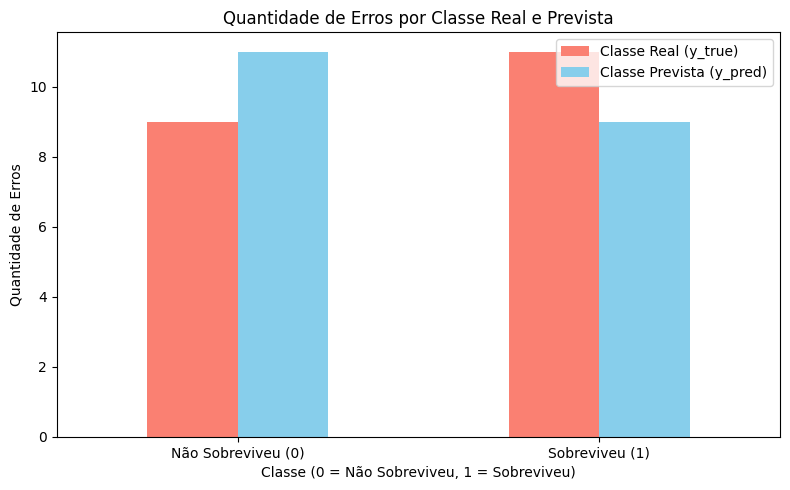

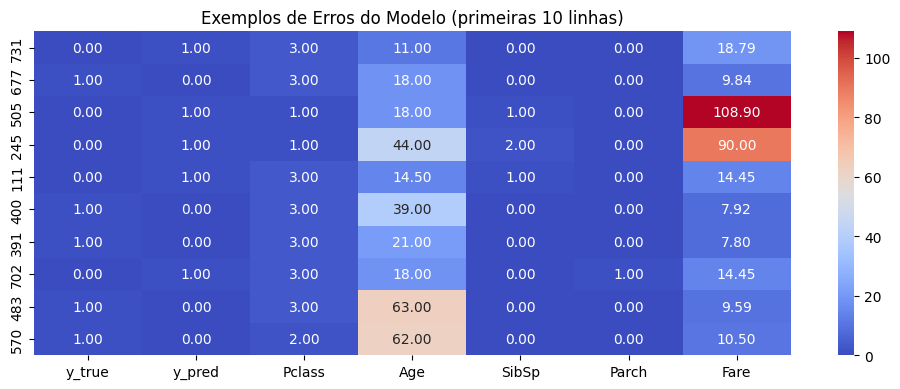

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Análise dos erros do modelo com plot
val_results = X_val.copy()
val_results['y_true'] = y_val.values
val_results['y_pred'] = val_pred
val_results['erro'] = val_results['y_true'] != val_results['y_pred']

# Unindo os dois gráficos em um só
erro_real = val_results[val_results['erro']].groupby('y_true').size()
erro_pred = val_results[val_results['erro']].groupby('y_pred').size()
df_erro = pd.DataFrame({'Classe Real (y_true)': erro_real, 'Classe Prevista (y_pred)': erro_pred})

df_erro.plot(kind='bar', color=['salmon', 'skyblue'], figsize=(8,5))
plt.title('Quantidade de Erros por Classe Real e Prevista')
plt.xlabel('Classe (0 = Não Sobreviveu, 1 = Sobreviveu)')
plt.ylabel('Quantidade de Erros')
plt.xticks([0,1], ['Não Sobreviveu (0)', 'Sobreviveu (1)'], rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

# Heatmap dos erros (mantido igual)
cols_to_show = ['y_true', 'y_pred']
for col in ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']:
    if col in val_results.columns:
        cols_to_show.append(col)

heatmap_data = val_results[val_results['erro']].head(10)[cols_to_show].astype(float)

plt.figure(figsize=(10,4))
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Exemplos de Erros do Modelo (primeiras 10 linhas)')
plt.tight_layout()
plt.show()

#### Análise de Erros por Classe Real e Prevista

O gráfico apresentado tem como objetivo ilustrar a **quantidade de erros** cometidos pelo modelo de classificação ao prever duas classes distintas: **"Não Sobreviveu (0)"** e **"Sobreviveu (1)"**.

##### Estrutura do Gráfico

- **Eixo Vertical (Y):** Representa a quantidade de erros.
- **Eixo Horizontal (X):** Representa as classes do problema.
- **Barras:**
  - **Vermelha:** Quantidade de erros na **classe real** (`y_true`).
  - **Azul:** Quantidade de erros na **classe prevista** (`y_pred`).

##### Interpretação dos Dados

- Para a classe **"Não Sobreviveu (0)"**:
  - Erros na classe real: **~8**
  - Erros na classe prevista: **~11**

- Para a classe **"Sobreviveu (1)"**:
  - Erros na classe real: **~11**
  - Erros na classe prevista: **~7**


#### Análise do Heatmap de Erros do Modelo

Este heatmap apresenta os **exemplos de erros cometidos pelo modelo** nas primeiras 10 linhas do conjunto de dados. Ele é uma ferramenta visual poderosa para identificar padrões e possíveis causas de erro nas previsões.

##### Objetivo

O objetivo do heatmap é destacar os valores das variáveis envolvidas nos erros de classificação, permitindo uma análise mais detalhada dos casos em que o modelo falhou.

##### Estrutura do Heatmap

- **Linhas:** Cada linha representa um exemplo (instância) onde o modelo errou.
- **Colunas:** As variáveis analisadas são:
  - `y_true`: Classe real
  - `y_pred`: Classe prevista
  - `Pclass`: Classe do passageiro (1ª, 2ª, 3ª)
  - `Age`: Idade
  - `SibSp`: Número de irmãos/cônjuges a bordo
  - `Parch`: Número de pais/filhos a bordo
  - `Fare`: Valor da tarifa paga

- **Cores:**
  - Azul: Valores baixos
  - Vermelho: Valores altos
  - A barra de cores à direita indica a escala de intensidade dos valores.


## Referências bibliográficas

- KAGGLE. Titanic - Machine Learning from Disaster. Disponível em: <https://www.kaggle.com/c/titanic>. Acesso em: 04 jul. 2025.

- TAVARES, Lucas. Dados desbalanceados: o que são e como evitá-los. *Turing Talks*, Medium, 2020. Disponível em: <https://medium.com/turing-talks/dados-desbalanceados-o-que-s%C3%A3o-e-como-evit%C3%A1-los-43df4f49732b>. Acesso em: 04 jul. 2025.

- Pandas: Python Data Analysis Library. Disponível em: <https://pandas.pydata.org/>. Acesso em: 04 jul. 2025.

- Scikit-learn: Machine Learning in Python. Disponível em: <https://scikit-learn.org/stable/>. Acesso em: 04 jul. 2025.